# Camunda Service Task Results Analysis

Here we analyse the results from running the `experiment-agent/coordinator.sh` script. 

The scripts run two different algorithms, one computationally simple, and the other computationally complex, at different concurrencies. These are done for 3 different implementations of a service task: Java Class, NodeJS External Task Client, and 2 NodeJS External Task Clients.

We use results obtained from running on my own computing device, a Macbook Pro 2019 with the following specs:
- 2.6 GHz 6-Core Intel Core i7
- 2 GB 2667 MHz DDR4

These results can be found in the `experiment-results-committed` folder.

## Preparation

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import json
import os
from pprint import pprint

from helpers import gray_out_ax

experiment_results_folder = './experiment-results-committed'

# get all results
results = []
result_files = os.listdir(experiment_results_folder)
for result_file in result_files:
  with open(f'{experiment_results_folder}/{result_file}') as f:
    run = json.load(f)
    results.append({
      "tag": run['tag'],
      "concurrent": run['concurrent'],
      "allDurationsInMillis": list(map(lambda datum: datum['durationInMillis'], run['processesData'])),
    })
    
# key by tag, then by concurrent
keyed = {}
for result in results:
  if not keyed.get(result['tag']):
    keyed[result['tag']] = {}
  keyed[result['tag']][result['concurrent']] = result

## 1. Basic tasks, 1 concurrent

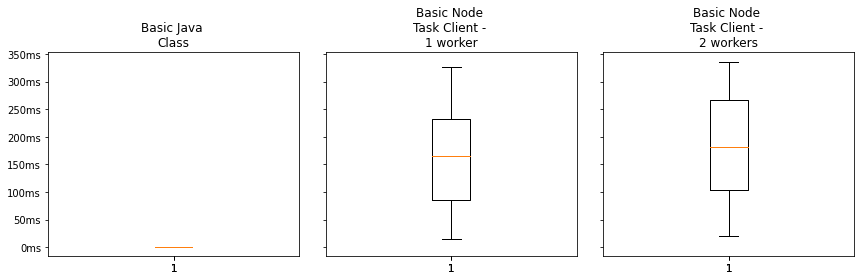

In [20]:
cols = [
  'Basic Java \nClass',
  'Basic Node \nTask Client - \n1 worker',
  'Basic Node \nTask Client - \n2 workers',
]
fig, axs = plt.subplots(1, len(cols), sharex=True, sharey=True, figsize=(12, 4))

for ax, col in zip(axs, cols):
    ax.set_title(col)

axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) + 'ms'))

fig.tight_layout()

axs[0].boxplot(keyed['basic-java-class']['1']['allDurationsInMill
                                              is'], showfliers=False)
axs[1].boxplot(keyed['basic-node-task-client-single-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[2].boxplot(keyed['basic-node-task-client-double-worker']['1']['allDurationsInMillis'], showfliers=False)

plt.savefig('./boxplots/1-basic-1-concurrent')
plt.show()

There is a stark difference between duration of the Java Class approach vs the external task client approach. What we see here could potentially be the effect of latency hits due to task clients use of [long polling](https://camunda.com/blog/2015/11/external-tasks/), and/or a performance difference between Java and NodeJS (must cite)

## 2. Basic tasks, introducing concurrency

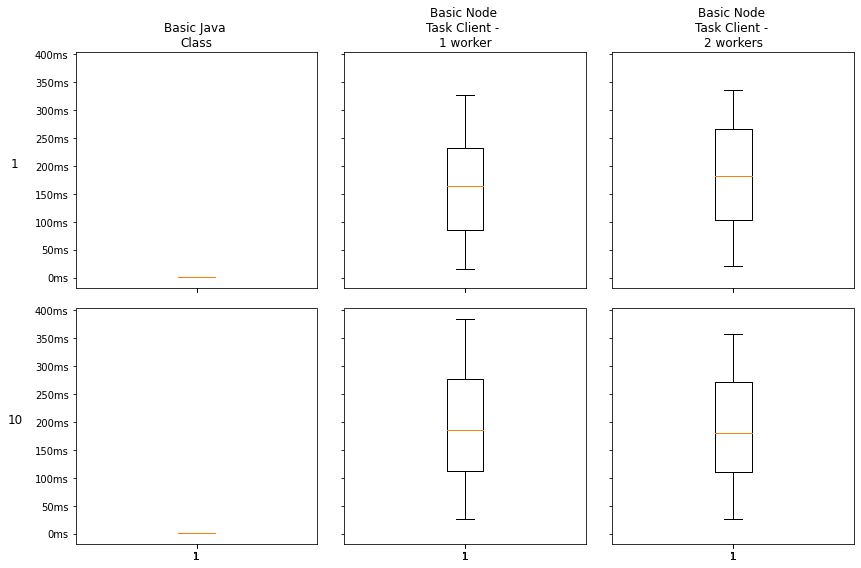

In [4]:
rows = ['1', '10']
cols = [
  'Basic Java \nClass',
  'Basic Node \nTask Client - \n1 worker',
  'Basic Node \nTask Client - \n2 workers',
]
fig, axs = plt.subplots(len(rows), len(cols), sharex=True, sharey=True, figsize=(12, 8))

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large', labelpad=20)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) + 'ms'))

fig.tight_layout()

axs[0,0].boxplot(keyed['basic-java-class']['1']['allDurationsInMillis'], showfliers=False)
axs[1,0].boxplot(keyed['basic-java-class']['10']['allDurationsInMillis'], showfliers=False)

axs[0,1].boxplot(keyed['basic-node-task-client-single-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[1,1].boxplot(keyed['basic-node-task-client-single-worker']['10']['allDurationsInMillis'], showfliers=False)

axs[0,2].boxplot(keyed['basic-node-task-client-double-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[1,2].boxplot(keyed['basic-node-task-client-double-worker']['10']['allDurationsInMillis'], showfliers=False)

plt.savefig('./boxplots/2a-basic-10-concurrent')
plt.show()

As observed before, the same pattern holds: there is a significant performance hit when comparing the Java Class approach versus a NodeJS task client approach. 

But bumping the concurrencies from 1 to 10 doesn't lead to much of a big difference. Let's push the envelope, and introduce concurrencies of 100 hits per second. 

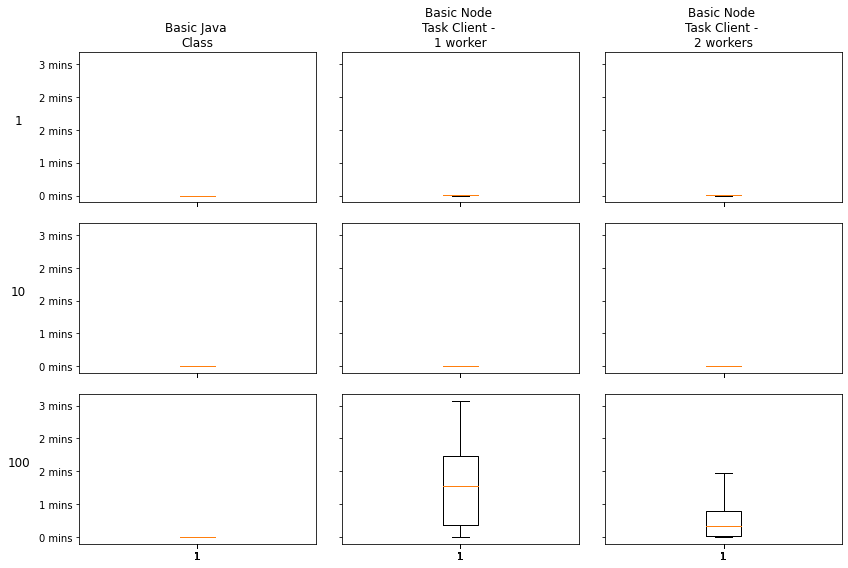

In [22]:
rows = ['1', '10', '100']
cols = [
  'Basic Java \nClass',
  'Basic Node \nTask Client - \n1 worker',
  'Basic Node \nTask Client - \n2 workers',
]
fig, axs = plt.subplots(len(rows), len(cols), sharex=True, sharey=True, figsize=(12, 8))

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large', labelpad=20)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000/60) + ' mins'))

fig.tight_layout()

axs[0,0].boxplot(keyed['basic-java-class']['1']['allDurationsInMillis'], showfliers=False)
axs[1,0].boxplot(keyed['basic-java-class']['10']['allDurationsInMillis'], showfliers=False)
axs[2,0].boxplot(keyed['basic-java-class']['100']['allDurationsInMillis'], showfliers=False)

axs[0,1].boxplot(keyed['basic-node-task-client-single-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[1,1].boxplot(keyed['basic-node-task-client-single-worker']['10']['allDurationsInMillis'], showfliers=False)
axs[2,1].boxplot(keyed['basic-node-task-client-single-worker']['100']['allDurationsInMillis'], showfliers=False)

axs[0,2].boxplot(keyed['basic-node-task-client-double-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[1,2].boxplot(keyed['basic-node-task-client-double-worker']['10']['allDurationsInMillis'], showfliers=False)
axs[2,2].boxplot(keyed['basic-node-task-client-double-worker']['100']['allDurationsInMillis'], showfliers=False)

plt.savefig('./boxplots/2b-basic-100-concurrent')
plt.show()

Here we see the external client approach getting crushed. Some possible reasons why:
- This could be the result of the throttling of max connections that Camunda can handle, because tasks cummulatively hang up
- NodeJS is [single threaded for non-IO operations](https://stackoverflow.com/questions/52646334/is-really-nodejs-singlethread-or-multithread), while it is possible that Camunda implements and handle multithreading within the engine itself. 
From the above we do see that process times hits can be offset to a certain extent by multiple task workers (as shown)

## With Advanced Tasks, 1 concurrent

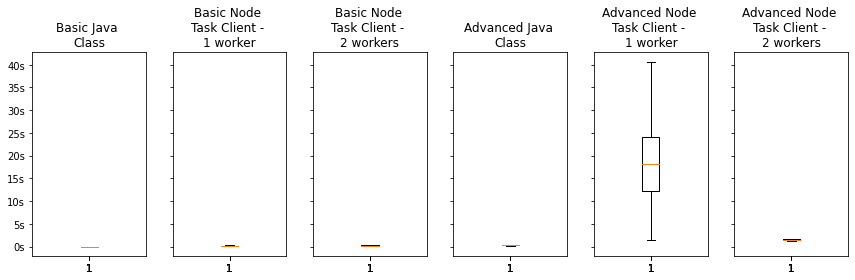

In [23]:
cols = [
  'Basic Java \nClass',
  'Basic Node \nTask Client - \n1 worker',
  'Basic Node \nTask Client - \n2 workers',
  'Advanced Java \nClass',
  'Advanced Node \nTask Client - \n1 worker',
  'Advanced Node \nTask Client - \n2 workers',
]
fig, axs = plt.subplots(1, len(cols), sharex=True, sharey=True, figsize=(12, 4))

for ax, col in zip(axs, cols):
    ax.set_title(col)

axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 's'))

fig.tight_layout()

axs[0].boxplot(keyed['basic-java-class']['1']['allDurationsInMillis'], showfliers=False)
axs[1].boxplot(keyed['basic-node-task-client-single-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[2].boxplot(keyed['basic-node-task-client-double-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[3].boxplot(keyed['advanced-java-class']['1']['allDurationsInMillis'], showfliers=False)
axs[4].boxplot(keyed['advanced-node-task-client-single-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[5].boxplot(keyed['advanced-node-task-client-double-worker']['1']['allDurationsInMillis'], showfliers=False)

plt.savefig('./boxplots/3a-advanced-1-concurrent')
plt.show()

Here we run a computationally intensive process, instead of the simple summation.

The result is that the Advanced Node Task Client Single worker dominates the scale - it is clearly unable to handle high concurrencies for computationally intensive tasks. But adding task workers helps (more than halve's processing time), so this could be the result of NodeJS' single threaded nature.

Let's remove Advanced Node Task Client Single and Double workers.

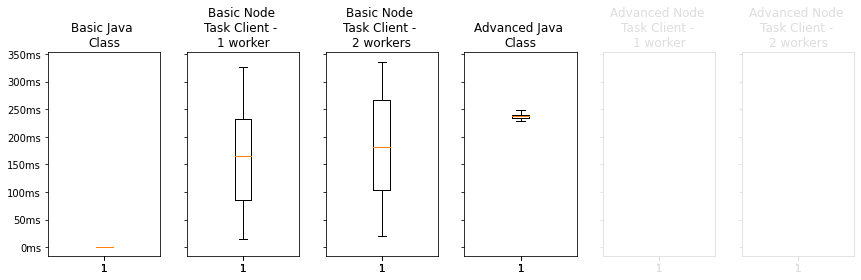

In [24]:
cols = [
  'Basic Java \nClass',
  'Basic Node \nTask Client - \n1 worker',
  'Basic Node \nTask Client - \n2 workers',
  'Advanced Java \nClass',
  'Advanced Node \nTask Client - \n1 worker',
  'Advanced Node \nTask Client - \n2 workers',
]
fig, axs = plt.subplots(1, len(cols), sharex=True, sharey=True, figsize=(12, 4))

for ax, col in zip(axs, cols):
    ax.set_title(col)

axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) + 'ms'))

fig.tight_layout()

axs[0].boxplot(keyed['basic-java-class']['1']['allDurationsInMillis'], showfliers=False)
axs[1].boxplot(keyed['basic-node-task-client-single-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[2].boxplot(keyed['basic-node-task-client-double-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[3].boxplot(keyed['advanced-java-class']['1']['allDurationsInMillis'], showfliers=False)
gray_out_ax(axs[4])
gray_out_ax(axs[5])

plt.savefig('./boxplots/3b-advanced-1-concurrent-minus-some')
plt.show()

- Java just crushes base. 
- It is interesting how the Java Class approaches have a much smaller spread than the NodeJS counterparts. 

## What about with concurrencies?

Let's see the all in view. 

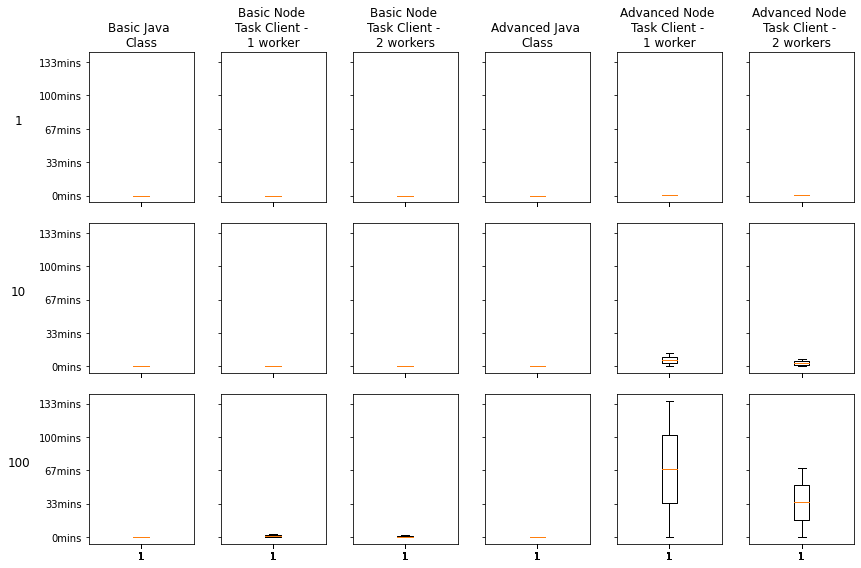

In [19]:
rows = ['1', '10', '100']
cols = [
  'Basic Java \nClass',
  'Basic Node \nTask Client - \n1 worker',
  'Basic Node \nTask Client - \n2 workers',
  'Advanced Java \nClass',
  'Advanced Node \nTask Client - \n1 worker',
  'Advanced Node \nTask Client - \n2 workers',
]
fig, axs = plt.subplots(len(rows), len(cols), sharex=True, sharey=True, figsize=(12, 8))

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large', labelpad=20)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000/60) + 'mins'))

fig.tight_layout()

axs[0,0].boxplot(keyed['basic-java-class']['1']['allDurationsInMillis'], showfliers=False)
axs[1,0].boxplot(keyed['basic-java-class']['10']['allDurationsInMillis'], showfliers=False)
axs[2,0].boxplot(keyed['basic-java-class']['100']['allDurationsInMillis'], showfliers=False)

axs[0,1].boxplot(keyed['basic-node-task-client-single-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[1,1].boxplot(keyed['basic-node-task-client-single-worker']['10']['allDurationsInMillis'], showfliers=False)
axs[2,1].boxplot(keyed['basic-node-task-client-single-worker']['100']['allDurationsInMillis'], showfliers=False)

axs[0,2].boxplot(keyed['basic-node-task-client-double-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[1,2].boxplot(keyed['basic-node-task-client-double-worker']['10']['allDurationsInMillis'], showfliers=False)
axs[2,2].boxplot(keyed['basic-node-task-client-double-worker']['100']['allDurationsInMillis'], showfliers=False)

axs[0,3].boxplot(keyed['advanced-java-class']['1']['allDurationsInMillis'], showfliers=False)
axs[1,3].boxplot(keyed['advanced-java-class']['10']['allDurationsInMillis'], showfliers=False)
axs[2,3].boxplot(keyed['advanced-java-class']['100']['allDurationsInMillis'], showfliers=False)

axs[0,4].boxplot(keyed['advanced-node-task-client-single-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[1,4].boxplot(keyed['advanced-node-task-client-single-worker']['10']['allDurationsInMillis'], showfliers=False)
axs[2,4].boxplot(keyed['advanced-node-task-client-single-worker']['100']['allDurationsInMillis'], showfliers=False)

axs[0,5].boxplot(keyed['advanced-node-task-client-double-worker']['1']['allDurationsInMillis'], showfliers=False)
axs[1,5].boxplot(keyed['advanced-node-task-client-double-worker']['10']['allDurationsInMillis'], showfliers=False)
axs[2,5].boxplot(keyed['advanced-node-task-client-double-worker']['100']['allDurationsInMillis'], showfliers=False)

plt.savefig('./boxplots/all')
plt.show()


An hour on average for the computationally intensive tasks on the NodeJS worker! Just incredible.

## Conclusions

The Java Class approach crushes base. Possibly because it is "native" to the Camunda engine, being compiled together with Camunda and directly called in the Camunda Engine.

This means tight coupling between service implementations and Camunda itself, but the performance gains are significantly better.

If Java is not in frequent use within the organisation, and there is a need to control technical diversity, task clients can be used if 
(1) the longer latencies are acceptable (different scenarios have different thresholds, speed is not always the most important factor), and/or 
(2) there is a willingness to utilise multiple task clients to ease bottlenecks. 
If these are acceptable conditions, task clients might make the application more scalable, because processing is offloaded from the main Camunda Engine. This last point needs to be tested further.